<a href="https://colab.research.google.com/github/o4lc/PINN-CBF/blob/main/DI/DI_DeepReach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DeepReach is also a physics informed method but enforces the HJ-PDE For finite time. We use the following parameterization to match the other baselines and because it should enhance the DeepReach method.
$$ h_{\theta}(x,t) = c(x) - \delta_{\theta}(x,t)$$
Substitute into the HJ-PDE found in equation (13) of Choi et al., 2021
$$\mathcal{L}_{HJ}(x,t;\theta, \gamma) = \min\bigg\{\delta_{\theta}(x,t), -\frac{\partial}{\partial t}\delta_{\theta}(x,t) +  \max_{u\in \mathcal{U}}
 \nabla_x(c(x) - \delta_{\theta}(x,t))^T(f(x) + g(x)u) + \gamma(c(x) - \delta_{\theta}(x,t))\bigg\}^2$$
$$\mathcal{L}_{T}(x,T;\theta, \gamma) = \delta_{\theta}(x,T)^2$$
$$\mathcal{L}(x,t;\theta, \gamma) = \mathcal{L}_{T}(x,T;\theta, \gamma) + \lambda \mathcal{L}_{HJ}(x,t;\theta, \gamma) $$

A cirriculum learning approach is used for training, where $\lambda = 0$ ininially and gradually increased. Spatial samples are kept constant throughout training.  

Using the filtering simulations from the other methods, we can set a reasonable time horizon to train on. Training time is scaled to $[0,T]$. Based on the past DI filtering simulations $T=20$ would be reasonable. We do not rescale time to $[0, 1]$ like in the paper because then space would also have to be rescaled leading to different error behavior of the residuals.

$$\lambda_T = 0,\; \lambda_0 = 1$$
DeepReach uses a cirrculum learning approach where $t$ is decreased linearly from $T$ and $\lambda$ regularizer increases linearly after being held at 0 for the first 1/11th of the iterations.

For validation we use the model at $t=0$.


(times and spatial coordinates are independent so times need not be stored)

In [ ]:
!pip install dill
import dill

In [ ]:
import jax
import numpy as onp
import jax.numpy as np
from jax import random, grad, hessian, vmap, jit, config, ops
from jax.nn import sigmoid, relu, elu, softplus, swish, tanh
from jax.example_libraries import optimizers
import jaxlib

import itertools
from functools import partial
from tqdm import trange
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.interpolate import interp1d
from scipy.linalg import block_diag

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.patches import Rectangle

import cvxpy as cp
import scipy.sparse as sp

from jax import tree_util

%matplotlib inline

In [ ]:
#For GPU use, check the device before importing anything from torch
jaxlib_version = jaxlib.__version__
print("jaxlib version:", jaxlib_version)
jax_version = jax.__version__
print("JAX version:", jax_version)
print(jax.local_devices())

jaxlib version: 0.4.33
JAX version: 0.4.33
[CudaDevice(id=0)]


In [ ]:
from torch.utils import data
print(jax.local_devices())

[CudaDevice(id=0)]


In [ ]:
# Build custom activation
def custom_softplus(x, beta=1):
    return (1 / beta) * np.log1p(np.exp(beta * x)) #This beta can't be large, causes gradient overflow during training
def custom_tanh(x, beta=1):
    return np.tanh(beta * x)

softplus = partial(custom_softplus, beta=1)
tanh = partial(custom_tanh, beta=1)

In [ ]:
##Hyperparameters

#Model
input_dim = 3 # 2 + time
output_dim = 1
layers = [3, 50, 50, 1]
activation = tanh #tanh, elu, custom
output_activation = softplus # softplus, swish, custom
cfunc_type = 'safety' #'safety', 'sdf'

#Cfunc
num_rect = 3
num_circ = 0
beta = 8
sharpness = 8

x_min, x_max, y_min, y_max = 0, 10, -5, 5
r_min, r_max, s_min, s_max = .5, 2, .5, 2
u = 1 #u_min, u_max = -1, 1

T = 20 #terminal time

#training
P_train = 10000 # number of random samples for training
batch_size = 10000
epochs = 30000

lambda_0 = 0
lambda_T = 1

ilr = 1e-4 #lr constant in their paper. It is possible that decaying stepsize works better but we dont try
flr = 1e-4
total_steps = epochs * (P_train / batch_size)

decay_rate = .8
if decay_rate < 1 and flr < ilr:
    decay_steps = int(total_steps * np.log(decay_rate) / np.log(flr/ilr))
else:
    decay_steps = 1e9

#Figure out lambda increase rate

#Residuals
gamma = .1
p = 2

#Validation
P_val = 100000

In [ ]:
#[theta, s1, s2, x_c, y_c]
def generate_rectangles(key, numrect):
    key_thetas, key_side1s, key_side2s, key_center1s, key_center2s = random.split(key, 5)
    thetas = random.uniform(key_thetas, shape=(numrect,), minval=0, maxval=2*np.pi)
    s1 = random.uniform(key_side1s, shape=(numrect,), minval=s_min, maxval=s_max)
    s2 = random.uniform(key_side2s, shape=(numrect,), minval=s_min, maxval=s_max)
    x_c = random.uniform(key_center1s, shape=(numrect,), minval=x_min, maxval=x_max)
    y_c = random.uniform(key_center2s, shape=(numrect,), minval=y_min, maxval=y_max)
    rectangles = np.column_stack((thetas, s1, s2, x_c, y_c))

    return rectangles

#[r, x_c, y_c]
def generate_circles(key, numcirc):
    key_radii, key_center1s, key_center2s = random.split(key, 3)
    radii = random.uniform(key_radii, shape=(numcirc,), minval=r_min, maxval=r_max)
    x_c = random.uniform(key_center1s, shape=(numcirc,), minval=x_min, maxval=x_max)
    y_c = random.uniform(key_center2s, shape=(numcirc,), minval=y_min, maxval=y_max)
    circles = np.column_stack((radii, x_c, y_c))

    return circles

# Set the seed for reproducibility
key = random.PRNGKey(20)
# Generate shapes

rectangles = [[0, 1, .5, 2, 0], [0, 1, 1, 3, 2], [np.pi/3, 1.5, .5, 6, 0]]
circles = generate_circles(key, num_circ)

print(rectangles)
print(circles)

[[0, 1, 0.5, 2, 0], [0, 1, 1, 3, 2], [1.0471975511965976, 1.5, 0.5, 6, 0]]
[]


In [ ]:
#c function
@jit
def rectangular_safety(x, y, s1, s2):
    # x, y are assumed inverted

    # Calculate distances from the edges of the rectangle
    dx_edge = abs(x) - s1 / 2
    dy_edge = abs(y) - s2 / 2

    # Calculate the minimum distance from the boundary
    max_out = np.maximum(dx_edge, dy_edge)

    return  max_out

@jit
def smooth_rectangular_safety(x, y, s1, s2, sharpness = sharpness):
    # x, y are assumed inverted

    # Calculate distances from the edges of the rectangle
    dx_edge = (np.log(np.exp(sharpness * x) + np.exp(sharpness * -x)) - np.log(2)) / sharpness - s1 / 2
    dy_edge = (np.log(np.exp(sharpness * y) + np.exp(sharpness * -y)) - np.log(2)) / sharpness - s2 / 2

    # Calculate the minimum distance from the boundary
    max_out = (np.log(np.exp(sharpness * dx_edge) + np.exp(sharpness * dy_edge)) - np.log(2)) / sharpness #Overuse of sharpness

    return  max_out

@jit
def cfunc(px, py, rectangles, circles):
    violations = []
    violations.append((px - x_min) * (x_max - px))
    violations.append((py - y_min) * (y_max - py))

    for rect in rectangles:

        theta, s1, s2, x_c, y_c = rect


        x_centered = px - x_c
        y_centered = py - y_c


        x_inv = x_centered * np.cos(-theta) - y_centered * np.sin(-theta)
        y_inv = x_centered * np.sin(-theta) + y_centered * np.cos(-theta)

        violations.append(rectangular_safety(x_inv, y_inv, s1, s2))

    for circ in circles:
         r, x_c, y_c, = circ

         violations.append((px - x_c)**2 + (py - y_c)**2 - r**2)

    return np.sign(np.min(np.array(violations)))


@jit
def smooth_cfunc(px, py, rectangles, circles, beta=beta):
    sum_exp = np.exp(-beta * np.tanh(px - x_min) * np.tanh(x_max - px)) + np.exp(-beta * np.tanh(py - y_min) * np.tanh(y_max - py))

    for rect in rectangles:

        theta, s1, s2, x_c, y_c = rect

        x_centered = px - x_c
        y_centered = py - y_c

        x_inv = x_centered * np.cos(-theta) - y_centered * np.sin(-theta)
        y_inv = x_centered * np.sin(-theta) + y_centered * np.cos(-theta)

        sum_exp += np.exp(-beta * np.tanh(smooth_rectangular_safety(x_inv, y_inv, s1, s2)))

    for circ in circles:
         r, x_c, y_c, = circ

         sum_exp += np.exp(-beta * np.tanh((px - x_c)**2 + (py - y_c)**2 - r**2))

    log_sum_exp = -np.log(sum_exp) / beta

    return log_sum_exp

In [ ]:
def visualize_cfunc(p=200, rectangles = rectangles, circles = circles):
    x_values = np.linspace(x_min - 1, x_max + 1, 200)
    y_values = np.linspace(y_min - 1, y_max + 1, 200)
    X, Y = np.meshgrid(x_values, y_values)
    X_flat = X.ravel()
    Y_flat = Y.ravel()

    # Compute Z values over the grid using vmap
    Z_flat = vmap(cfunc, (0, 0, None, None))(X_flat, Y_flat, rectangles, circles)
    Z_flat_smooth = vmap(smooth_cfunc, (0, 0, None, None))(X_flat, Y_flat, rectangles, circles)

    Z = Z_flat.reshape(X.shape)
    Z_smooth = Z_flat_smooth.reshape(X.shape)

    # Calculate the difference
    Z_difference = Z - Z_smooth

    # Plotting
    fig, ax = plt.subplots(1, 3, figsize=(24, 7))  # Adjusted for three plots

    # Plot Z
    cp1 = ax[0].contourf(X, Y, Z, levels=50, cmap='coolwarm')
    contour1 = ax[0].contour(X, Y, Z, levels=[0], colors='k', linestyles='--')
    fig.colorbar(cp1, ax=ax[0])
    ax[0].set_title('cfunc Contour Plot')
    ax[0].set_xlabel('X coordinate')
    ax[0].set_ylabel('V coordinate')

    # Plot Z_smooth
    cp2 = ax[1].contourf(X, Y, Z_smooth, levels=50, cmap='coolwarm')
    contour2 = ax[1].contour(X, Y, Z_smooth, levels=[0], colors='k', linestyles='--')
    fig.colorbar(cp2, ax=ax[1])
    ax[1].set_title('Smooth cfunc Contour Plot')
    ax[1].set_xlabel('X coordinate')
    ax[1].set_ylabel('V coordinate')

    # Plot difference
    cp3 = ax[2].contourf(X, Y, Z_difference, levels=50, cmap='coolwarm')
    contour3 = ax[2].contour(X, Y, Z_difference, levels=[0], colors='k', linestyles='--')
    fig.colorbar(cp3, ax=ax[2])
    ax[2].set_title('Difference (Z - Z_smooth)')
    ax[2].set_xlabel('X coordinate')
    ax[2].set_ylabel('V coordinate')

    plt.tight_layout()
    plt.show()

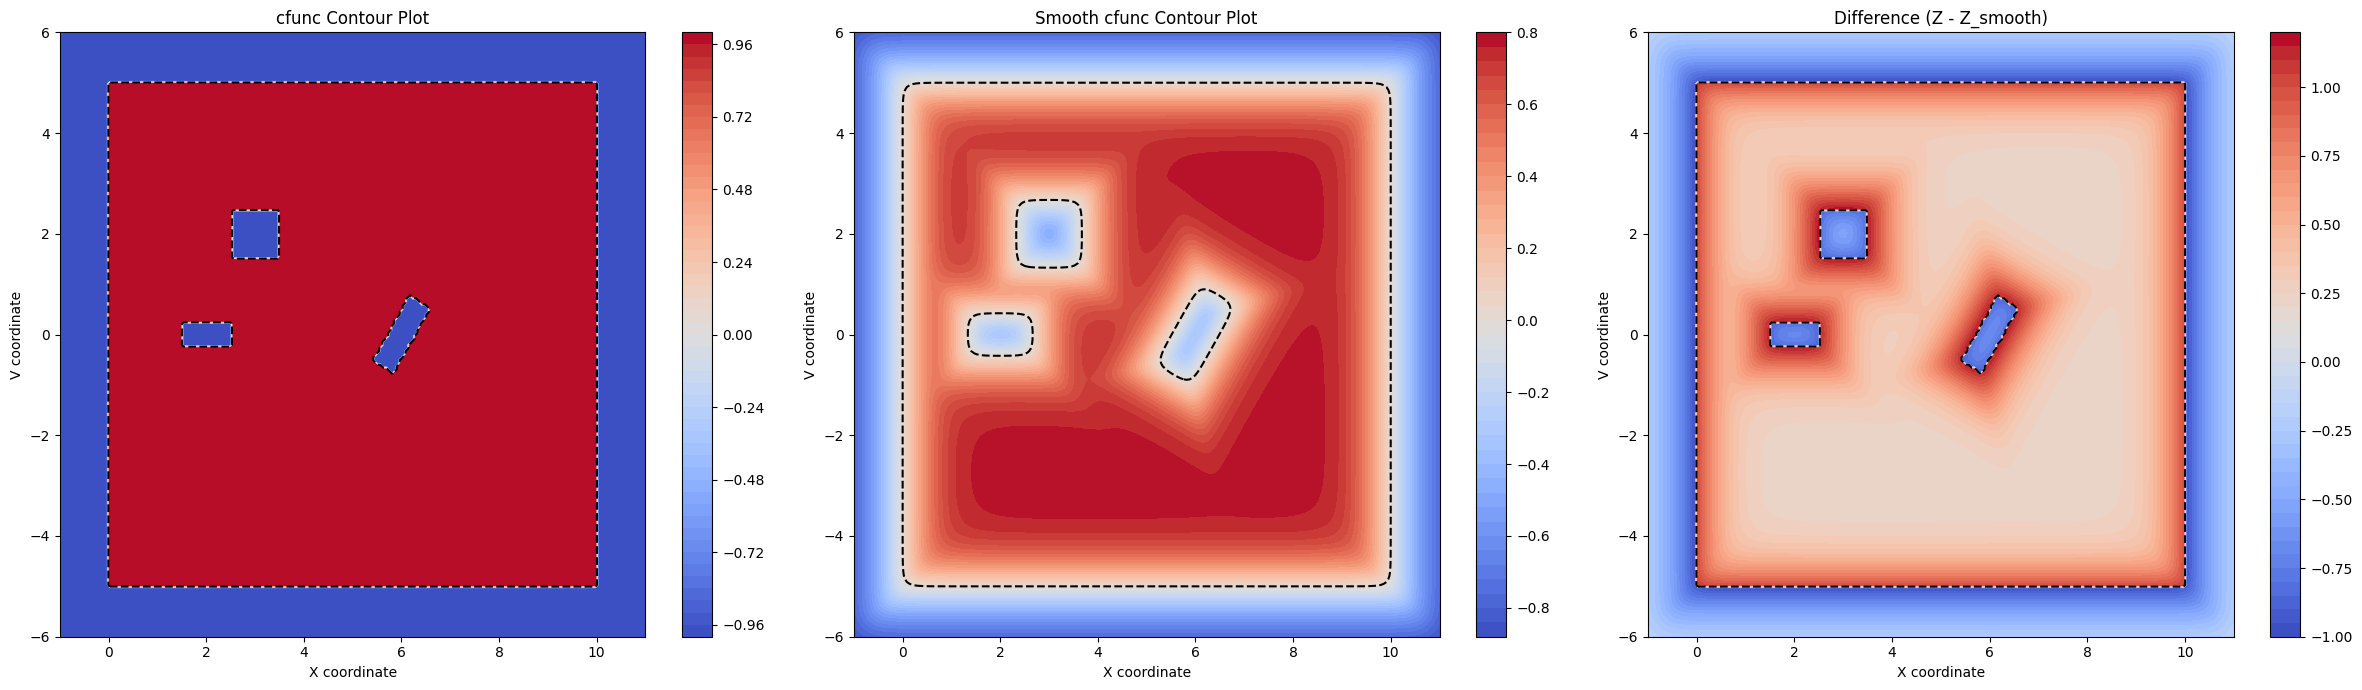

In [ ]:
visualize_cfunc()

In [ ]:
#arbitrary smooth activation van be passed like elu, tanh, silu, softplus, or custom
def MLP(layers, activation=tanh, use_batchnorm=False, init_last_zeros=False, noise_std=1e-8):
    ''' MLP with optional BatchNorm'''
    def init(rng_key):
        def init_layer(key, d_in, d_out, init_zeros=False):
            k1, k2 = random.split(key)
            if init_zeros:
                # W = np.zeros((d_in, d_out))
                # b = np.zeros(d_out)
                W = noise_std * random.normal(k1, (d_in, d_out))
                b = noise_std * random.normal(k2, (d_out,))
            else:
                glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
                W = glorot_stddev * random.normal(k1, (d_in, d_out))
                b = np.zeros(d_out)
            if use_batchnorm:
                # Initialize batchnorm parameters
                scale = np.ones(d_out)
                offset = np.zeros(d_out)
                return W, b, scale, offset
            else:
                return W, b

        key, *keys = random.split(rng_key, len(layers))
        if init_last_zeros:
            params = list(map(init_layer, keys[:-1], layers[:-1], layers[1:], [False]*(len(layers)-1)))
            last_layer_params = init_layer(keys[-1], layers[-2], layers[-1], True)
            params.append(last_layer_params)
        else:
            params = list(map(init_layer, keys, layers[:-1], layers[1:]))
        return params

    def apply(params, inputs, is_training=True):
        for layer_params in params[:-1]:
            W, b = layer_params[:2]  # Get weights and biases
            outputs = np.dot(inputs, W) + b
            if use_batchnorm:
                # Extract batchnorm parameters
                scale, offset = layer_params[2:]
                # Compute batch normalization manually
                mean = np.mean(outputs, axis=0)
                variance = np.var(outputs, axis=0)
                normalized_outputs = (outputs - mean) / np.sqrt(variance + 1e-5)
                outputs = scale * normalized_outputs + offset
            outputs = activation(outputs)
            inputs = outputs
        W, b = params[-1][:2]  # Last layer weights and biases
        outputs = np.dot(inputs, W) + b
        return outputs

    return init, apply

In [ ]:
class DataGenerator(data.Dataset):
    def __init__(self, y, c, gradc, batch_size=64, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.y = y  # Queries
        self.c = c  # Safety function values corresponding to queries
        self.gradc = gradc

        self.N = y.shape[0]
        self.batch_size = min(batch_size, self.N)  # Ensure batch_size is smaller than N
        self.key = rng_key

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        y, c, gradc = self.__data_generation(subkey)
        return y, c, gradc

    def __len__(self):
        'Denotes the total number of samples'
        return self.N

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        y = self.y[idx, :]
        c = self.c[idx, :]
        gradc = self.gradc[idx, :]

        return y, c, gradc

In [ ]:
#We only sample the spatial data
#Gradient of cfuncs
def get_gradc(y1, y2, rectangles, circles):
    gradc_y1 = grad(smooth_cfunc, argnums=0)(y1, y2, rectangles, circles)
    gradc_y2 = grad(smooth_cfunc, argnums=1)(y1, y2, rectangles, circles)

    # Return the gradients and the Hessian components
    return np.array([gradc_y1, gradc_y2])
#Validation happens at T = 0
def sample_training_data(key, P=P_train, rectangles=rectangles, circles=circles, sample_outside=True):
    # Generate a batch of random samples
    def generate_samples(key, num_samples):
        key1, key2 = random.split(key)
        x_samples = random.uniform(key1, (num_samples,), minval=x_min - (1 - sample_outside), maxval=x_max + (1 - sample_outside))
        y_samples = random.uniform(key2, (num_samples,), minval=y_min - (1 - sample_outside), maxval=y_max + (1 - sample_outside))
        return np.column_stack((x_samples, y_samples)) #multiple samples so use column stack

    # Unified function to compute c values
    def compute_c_values(y_samples):
        c_values_smooth = vmap(smooth_cfunc, (0, 0, None, None))(y_samples[:, 0], y_samples[:, 1], rectangles, circles)
        #c_values_normal = vmap(cfunc, (0, 0, None, None))(y_samples[:, 0], y_samples[:, 1], rectangles, circles)
        #return np.where(smooth, c_values_smooth, c_values_normal)
        return c_values_smooth

    # Main sampling loop
    y_list = []
    if sample_outside:
        while len(y_list) < P:
            # Generate a batch of samples
            key, subkey = random.split(key)
            batch_size = P - len(y_list) # Adaptive batch size strategy
            y_samples = generate_samples(subkey, batch_size)

            # Compute c values for the entire batch
            c_values = compute_c_values(y_samples)

            # Create a boolean mask for valid samples
            valid_mask = c_values >= 0
            valid_samples = y_samples[valid_mask]

            # Append valid samples to the list
            y_list.extend(valid_samples.tolist())
    else:
         y_samples = generate_samples(key, P)
         y_list.extend(y_samples.tolist())

    # Convert list to array
    y = np.array(y_list)

    # Compute values for c, gradc at sampled points
    c = vmap(smooth_cfunc, (0, 0, None, None))(y[:, 0], y[:, 1], rectangles, circles)
    gradc = vmap(get_gradc, (0, 0, None, None))(y[:, 0], y[:, 1], rectangles, circles)

    return y, c, gradc


def sample_validation_data(P=P_val, rectangles=rectangles, circles=circles, sample_outside=True):
    # Generate a uniform mesh of points
    x_vals = np.linspace(x_min - (1 - sample_outside), x_max + (1 - sample_outside), int(np.sqrt(P)))
    y_vals = np.linspace(y_min - (1 - sample_outside), y_max + (1 - sample_outside), int(np.sqrt(P)))
    mesh = np.array(np.meshgrid(x_vals, y_vals)).T.reshape(-1, 2)  # Reshape into (N, 2)

    if sample_outside:
        # Compute the smooth_cfunc values for all mesh points
        c_values = vmap(smooth_cfunc, (0, 0, None, None))(mesh[:, 0], mesh[:, 1], rectangles, circles)
        # Keep only the points where smooth_cfunc is non-negative (outside obstacles)
        valid_indices = c_values >= 0
        mesh = mesh[valid_indices]

    # Compute values for c and gradc at the remaining mesh points
    c = vmap(smooth_cfunc, (0, 0, None, None))(mesh[:, 0], mesh[:, 1], rectangles, circles)
    gradc = vmap(get_gradc, (0, 0, None, None))(mesh[:, 0], mesh[:, 1], rectangles, circles)

    return mesh, c, gradc

In [ ]:
class PI_MLP:
    def __init__(self, layers, y_val, c_val, gradc_val, p=p, activation=tanh, T = T, output_activation=softplus, use_batchnorm=False, init_last_zeros = False):
        # Network initialization and evaluation functions
        self.y_val = y_val
        self.c_val = c_val
        self.gradc_val = gradc_val
        self.T = T
        self.init, self.apply = MLP(layers, activation=activation, use_batchnorm=use_batchnorm, init_last_zeros=init_last_zeros)
        self.p = p
        self.output_activation = output_activation

        # Loss function

        # Initialize
        params = self.init(rng_key=random.PRNGKey(1234))

        # Use optimizers to set optimizer initialization and update functions
        self.opt_init, self.opt_update, self.get_params = optimizers.adam(optimizers.exponential_decay(ilr, decay_steps=decay_steps, decay_rate=decay_rate))

        # Initialize optimizer state for both phases
        self.opt_state = self.opt_init(params)

        self.itercount = itertools.count()

        self.nIter = int(P_train / batch_size * epochs)

        # Logger
        #Build validation at t=0 so this can be logged
        self.HJ_validation_log = []
        self.safety_validation_log = []
        self.rel_volume_log = []


    def update_nIter(self, epochs_new):
        self.nIter = int(P_train / batch_size * epochs_new)

    def plot_validation(self):
        # Create a figure with two subplots
        fig, axs = plt.subplots(1, 3, figsize=(18, 6))

        # Plot HJ validation loss on the first subplot
        axs[0].plot(self.HJ_validation_log, label='HJ Validation Loss', color='blue')
        axs[0].set_xlabel('Iteration')
        axs[0].set_ylabel('Loss')
        axs[0].set_title('HJ Validation Loss')
        axs[0].legend()

        # Plot CBF validation loss on the second subplot
        axs[1].plot(self.safety_validation_log, label='Safety Validation Loss', color='orange')
        axs[1].set_xlabel('Iteration')
        axs[1].set_ylabel('Loss')
        axs[1].set_title('Safety Validation Loss')
        axs[1].legend()

        # Plot CBF validation loss on the second subplot
        axs[2].plot(self.rel_volume_log, label='Relative Volume Loss', color='green')
        axs[2].set_xlabel('Iteration')
        axs[2].set_ylabel('Loss')
        axs[2].set_title('Relative Volume')
        axs[2].legend()


        # Adjust layout to prevent overlap
        plt.tight_layout()

        # Show plot
        plt.show()

    #Plotting function for visualization
    def plot_predictions(self, t = 0, P = 200):
        y1 = np.linspace(-1, 11, P)
        y2 = np.linspace(-6, 6, P)
        y1, y2 = np.meshgrid(y1, y2)
        y = np.hstack((y1.flatten()[:, None], y2.flatten()[:, None]))  # shape = (P**2, 2)
        # Evaluate smooth_cfunc over y

        c = vmap(smooth_cfunc, (0, 0, None, None))(y[:, 0], y[:, 1], rectangles, circles)

        # Plotting
        fig, ax = plt.subplots(1, 2, figsize=(14, 6))  # Adjusted for three plots

        # Plot c
        cp1 = ax[0].contourf(y1, y2, c.reshape(P, P), levels=50, cmap='coolwarm')
        contour1 = ax[0].contour(y1, y2, c.reshape(P, P), levels=[0], colors='black')
        fig.colorbar(cp1, ax=ax[0])
        ax[0].set_title('cfunc Contour Plot')
        ax[0].set_xlabel('x')
        ax[0].set_ylabel('v')

        # Generate predictions for CBF
        params = self.get_params(self.opt_state)
        outputs = vmap(self.net_diff, (None, 0, 0, None))(params, y[:, 0], y[:, 1], t)

        h = c - outputs

        # Plot CBF
        cp2 = ax[1].contourf(y1, y2, h.reshape(P, P), levels=50, cmap='coolwarm')
        contour2 = ax[1].contour(y1, y2, h.reshape(P, P), levels=[0], colors='black')
        fig.colorbar(cp2, ax=ax[1])
        ax[1].set_title('CBF')
        ax[1].set_xlabel('x')
        ax[1].set_ylabel('v')

        plt.tight_layout()
        plt.show()

    def net_diff(self, params, y1, y2, t):
        input_vector = np.hstack([y1, y2, t])
        out = np.squeeze(self.apply(params, input_vector))
        output = self.output_activation(out)

        return output

    def residuals(self, params, y1, y2, t, c, c_y1, c_y2, gamma=gamma):
        res_T = self.net_diff(params, y1, y2, self.T) #delta_T

        delta = self.net_diff(params, y1, y2, t)
        delta_t = grad(self.net_diff, argnums=3)(params, y1, y2, t)
        delta_y1 = grad(self.net_diff, argnums=1)(params, y1, y2, t)
        delta_y2 = grad(self.net_diff, argnums=2)(params, y1, y2, t)
        h = c - delta

        h_y1 = self.derivative_h(c_y1, delta_y1)
        h_y2 = self.derivative_h(c_y2, delta_y2)

        res_HJ = np.min(np.array([delta, -delta_t + y2 * h_y1 + u * np.abs(h_y2) + gamma * h ]))

        return np.array([res_T, res_HJ])


    def derivative_h(self, dc, ddelta):
        return dc  -  ddelta

    def validation_residuals(self, params, y1, y2, c, c_y1, c_y2, gamma=gamma):
        #the steady state HJ-PDE residuals are evaluated at for validation at t=0
        delta = self.net_diff(params, y1, y2, 0)
        delta_y1 = grad(self.net_diff, argnums=1)(params, y1, y2, 0)
        delta_y2 = grad(self.net_diff, argnums=2)(params, y1, y2, 0)
        h = c - delta

        h_y1 = self.derivative_h(c_y1, delta_y1)
        h_y2 = self.derivative_h(c_y2, delta_y2)

        res_I = np.min(np.array([delta, y2 * h_y1 + u * np.abs(h_y2) + gamma * h ]))
        res_II = relu(- y2 * h_y1 - u * np.abs(h_y2) - gamma * h)

        return np.array([res_I, np.squeeze(res_II)])

    def loss(self, params, batch, t):
        # Fetch data
        y, c, gradc = batch
        c_squeeze = np.squeeze(c)
        # Compute forward pass
        pred = vmap(self.residuals, (None, 0, 0, None, 0, 0, 0))(params, y[:, 0], y[:, 1], t, c_squeeze, gradc[:, 0], gradc[:, 1])
        # Compute loss
        lamb = abs(T - t) / T
        loss_T = np.mean(pred[:, 0])
        loss_HJ = np.mean(pred[:, 1]**2) #is abs better?

        return loss_T + lamb * loss_HJ

    # Define a compiled update step for phase
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, batch, t):
        params = self.get_params(opt_state)
        g = grad(self.loss)(params, batch, t) #The grad function will automatically differentiate only with respect to the first argument (params)
        return self.opt_update(i, g, opt_state)

    def train(self, train_dataset):
        data = iter(train_dataset)

        pbar = trange(self.nIter)
        for it in pbar:

            # Calculate t based on the current iteration, 1/11 follows from the DeepReach paper
            frac = it / self.nIter
            t = np.where(
            frac < 1/11,
            self.T,
            self.T * (1 - (frac - 1/11) / (1 - 1/11))
            )

            batch = next(data)

            self.opt_state = self.step(next(self.itercount), self.opt_state, batch, t)

            if it % 100 == 0:
                params = self.get_params(self.opt_state)

                # Compute Validation losses
                c_val_squeeze = np.squeeze(self.c_val)
                validation_residuals = vmap(self.validation_residuals, (None, 0, 0, 0, 0, 0))(params, self.y_val[:, 0], self.y_val[:, 1], c_val_squeeze, self.gradc_val[:, 0], self.gradc_val[:, 1])
                res_HJ = np.abs(validation_residuals[:, 0])
                res_CBF = validation_residuals[:, 1]

                safety = np.where(c_val_squeeze>=0, res_CBF, 0)

                delta_val = vmap(self.net_diff, (None, 0, 0, None))(params, self.y_val[:,0], self.y_val[:,1], 0)
                h_val = c_val_squeeze - delta_val

                # Compute relative volume
                rel_vol = np.mean(h_val >= 0)

                # Store validation metrics
                loss_HJ = np.mean(res_HJ)
                loss_safety = np.mean(safety)
                HJ = np.mean(validation_residuals[:, 0])
                self.HJ_validation_log.append(np.mean(loss_HJ))
                self.safety_validation_log.append(loss_safety)
                self.rel_volume_log.append(rel_vol)

                # Print losses
                pbar.set_postfix({'HJ Loss': loss_HJ, ' Safety': loss_safety, 'Relative Volume': rel_vol, 'time': t})

In [ ]:
# validation is always in the case where samples are outside the smoothed obstacles
def validation(model, y_val, c_val, gradc_val, gamma=gamma):
        ndata = y_val.shape[0]
        params = model.get_params(model.opt_state)

        res_both = vmap(model.validation_residuals, (None, 0, 0, 0, 0, 0))(params, y_val[:,0], y_val[:,1], c_val, gradc_val[:,0], gradc_val[:,1])

        res_I = res_both[:,0]
        res_II = res_both[:,1]
        abs_res_I = np.abs(res_I)

        delta_val = vmap(model.net_diff, (None, 0, 0, None))(params, y_val[:,0], y_val[:,1], 0)
        h_val = c_val - delta_val

        # Compute relative volume
        rel_vol = np.mean(h_val >= 0)

        # Compute other metrics
        avg_abs_res_I = np.mean(abs_res_I)
        max_abs_res_I = np.max(abs_res_I)
        std_abs_res_I = np.std(abs_res_I)
        avg_safety = np.mean(res_II)

        # Print the calculated values
        print(f"Average of abs_res_I: {avg_abs_res_I}")
        print(f"Maximum of abs_res_I: {max_abs_res_I}")
        print(f"Standard deviation of abs_res_I: {std_abs_res_I}")
        print(f"Average of safety: {avg_safety}")
        print(f"Relative volume: {rel_vol}")

##Train

In [ ]:
#Sample data
key = random.PRNGKey(0)
y_train_full,  c_train_full, gradc_train_full = sample_training_data(key, sample_outside=False)

y_val_outside, c_val_outside, gradc_val_outside = sample_validation_data(sample_outside=True)

In [ ]:
#Build Datagenerator
training_data = DataGenerator(y_train_full, np.expand_dims(c_train_full, axis = 1), gradc_train_full, batch_size=batch_size)

In [ ]:
epochs = epochs
DI_DeepReach = PI_MLP(layers, y_val_outside, c_val_outside, gradc_val_outside, p=p, activation=tanh, output_activation=softplus, use_batchnorm=False, init_last_zeros = False)

100%|██████████| 30000/30000 [01:59<00:00, 251.87it/s, HJ Loss=0.3753205,  Safety=0.30395573, Relative Volume=0.8304059, time=0.07333333]


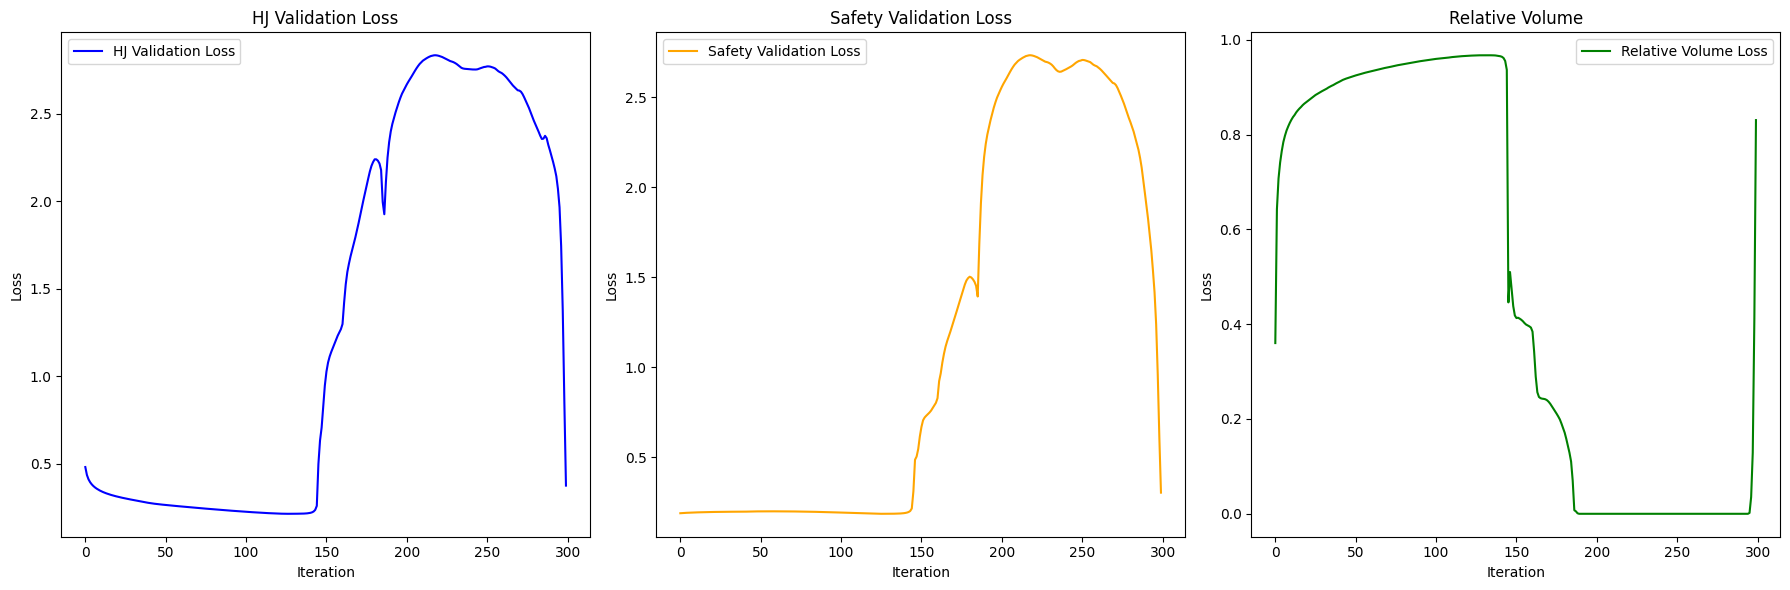

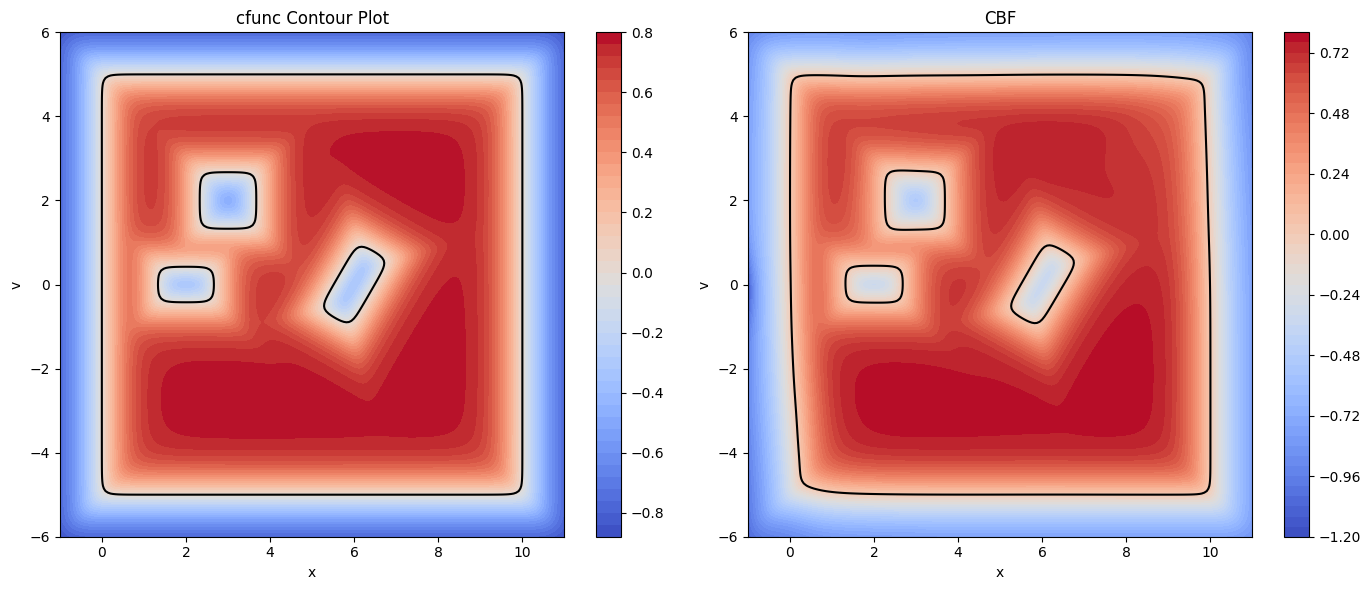

In [ ]:
#Decaying stepsize
DI_DeepReach.train(training_data)
DI_DeepReach.plot_validation()
DI_DeepReach.plot_predictions()

In [ ]:
#Save and load the models
with open('DI_DeepReach.pkl', 'wb') as f:
    dill.dump(DI_DeepReach, f)

# with open('DI_DeepReach.pkl', 'rb') as f:
#     DI_DeepReach = dill.load(f)

##Final Validation

In [ ]:
validation(DI_DeepReach, y_val_outside, c_val_outside, gradc_val_outside)

Average of abs_res_I: 0.2063220888376236
Maximum of abs_res_I: 4.343782901763916
Standard deviation of abs_res_I: 0.5985198020935059
Average of safety: 0.19505196809768677
Relative volume: 0.9842259883880615
